# 1. Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display
import IPython.display as ipd  # To play sound in the notebook
import random


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

sns.set_style("whitegrid")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# 2. Data Collection

In [2]:
RAVDESS = "./data/ravdess-emotional-speech-audio/"
CREMA = "./data/cremad/"
TESS = "./data/toronto-emotional-speech-set-tess/"
SAVEE = "./data/surrey-audiovisual-expressed-emotion-savee/"

## 2.1. Ravdess dataframe

In [3]:
ravdess_actors_list = os.listdir(RAVDESS)
audio_emotion = []
audio_path = []
audio_gender = []
audio_intensity = []
durations = []

for file in ravdess_actors_list:
    actor = os.listdir(os.path.join(RAVDESS,file))
    for audio in actor:
        list_audio = audio.split('.')[0] # splitting by the '.' into '**-**-**' . 'wav' and grab the first element
        list_audio = list_audio.split('-') # splitting by the dash
        gender_code = int(list_audio[6])
        
        audio_emotion.append(int(list_audio[2])) # the third element describes the emotion class
        audio_gender.append('female' if gender_code & 1 == 0 else 'male') # the sixth element describes the voice gender 
        audio_intensity.append('normal' if int(list_audio[3]) == 1 else 'high')
        audio_path.append(os.path.join(RAVDESS,file,audio))
        
        audio, sr = librosa.load(os.path.join(RAVDESS,file,audio))
        durations.append(librosa.get_duration(y=audio, sr=sr))

ravdess_df = pd.DataFrame({'emotions': audio_emotion, 'genders': audio_gender, 'audio_intensity': audio_intensity, 'audio_path': audio_path, 'duration':durations})

# Mapping the values to emotions
emotion_dict = {
    1: 'neutral',
    2: 'neutral', # originally - - > 'calm'
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprised',
}

# Replace the values in the column with emotions
ravdess_df['emotions'] = ravdess_df['emotions'] .replace(emotion_dict)
ravdess_df['dataset'] = 'ravdess'
ravdess_df.head()

,emotions,genders,audio_intensity,audio_path,duration,dataset
0,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.303311,ravdess
1,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.336689,ravdess
2,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.269932,ravdess
3,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.169841,ravdess
4,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.536871,ravdess


## 2.2. Crema dataframe

In [4]:
crema_list = os.listdir(CREMA)
audio_emotion = []
audio_path = []
audio_intensity = []
gender_list = []
durations = []

female_id_list = [
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018', 
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047', 
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072', 
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
]

emotion_dict = {
    'HAP' : 'happy',
    'NEU' : 'neutral',
    'SAD' : 'sad',
    'ANG' : 'angry',
    'FEA' : 'fear',
    'DIS' : 'disgust',
}

intensity_dict = {
    'XX' : 'normal',
    'X' : 'normal',
    'LO' : 'low',
    'MD' : 'normal',
    'HI': 'high'
}

for audio in crema_list:
    list_audio = audio.split('.')[0] # splitting by the '.' into '**-**-**' . 'wav' and grab the first element
    list_audio = list_audio.split('_') # splitting by the underline
    audio_emotion.append(list_audio[2])
    audio_intensity.append(list_audio[3])
    audio_path.append(os.path.join(CREMA,audio))
    gender_list.append('female' if list_audio[0] in female_id_list else 'male')
    
    audio, sr = librosa.load(os.path.join(CREMA,audio))
    durations.append(librosa.get_duration(y=audio, sr=sr))
    

crema_df = pd.DataFrame({'emotions': audio_emotion, 'genders': gender_list, 'audio_intensity': audio_intensity, 'audio_path': audio_path, 'duration':durations})
crema_df['emotions'] = crema_df['emotions'].replace(emotion_dict)
crema_df['audio_intensity'] = crema_df['audio_intensity'].replace(intensity_dict)
crema_df['dataset'] = 'crema'
crema_df.head()

,emotions,genders,audio_intensity,audio_path,duration,dataset
0,angry,male,normal,./data/cremad/1001_DFA_ANG_XX.wav,2.275601,crema
1,disgust,male,normal,./data/cremad/1001_DFA_DIS_XX.wav,2.335692,crema
2,fear,male,normal,./data/cremad/1001_DFA_FEA_XX.wav,2.168844,crema
3,happy,male,normal,./data/cremad/1001_DFA_HAP_XX.wav,1.868526,crema
4,neutral,male,normal,./data/cremad/1001_DFA_NEU_XX.wav,2.035420,crema


## 2.3. TESS dataframe

In [5]:
tess_dir_list = os.listdir(TESS)
path_list = []
gender_list = []
emotion_list = [] 
audio_intensity = []
durations = []

emotion_dict = {
    'happy'   : 'happy',
    'neutral' : 'neutral',
    'sad'     : 'sad',
    'ps'     : 'surprised',
    'angry'   : 'angry',
    'fear'    : 'fear',
    'disgust'  : 'disgust',
}

for directory in tess_dir_list:
    audio_files = os.listdir(os.path.join(TESS, directory))
    for audio_file in audio_files:
        part = audio_file.split('.')[0]
        path_list.append(os.path.join(TESS,directory,audio_file))
        gender_list.append('female') # female only dataset
        audio_intensity.append('normal') # normal only dataset
        emotion_list.append(part.split('_')[2])
        
        audio, sr = librosa.load(os.path.join(TESS,directory,audio_file))
        durations.append(librosa.get_duration(y=audio, sr=sr))
            
tess_df = pd.DataFrame({'emotions': emotion_list, 'genders': gender_list, 'audio_intensity': audio_intensity, 'audio_path': path_list, 'duration':durations})
tess_df['emotions'] = tess_df['emotions'].replace(emotion_dict)
tess_df['dataset'] = 'tess'
tess_df.head()

,emotions,genders,audio_intensity,audio_path,duration,dataset
0,angry,female,normal,./data/toronto-emotional-speech-set-tess/OAF_a...,1.539048,tess
1,angry,female,normal,./data/toronto-emotional-speech-set-tess/OAF_a...,1.616644,tess
2,angry,female,normal,./data/toronto-emotional-speech-set-tess/OAF_a...,1.542041,tess
3,angry,female,normal,./data/toronto-emotional-speech-set-tess/OAF_a...,1.606893,tess
4,angry,female,normal,./data/toronto-emotional-speech-set-tess/OAF_a...,1.395193,tess


## 2.3. SAVEE dataframe

In [6]:
savee_dir_list = os.listdir(SAVEE)
path_list = []
gender_list = []
emotion_list = []
audio_intensity = []
durations = []

emotion_dict = {
    'h'  : 'happy',
    'n'  : 'neutral',
    'sa' : 'sad',
    'a'  : 'angry',
    'f'  : 'fear',
    'd'  : 'disgust',
    'su' : 'surprised'
}

for audio_file in savee_dir_list:
    part = audio_file.split('_')[1]
    path_list.append(os.path.join(SAVEE,audio_file))
    gender_list.append('male') # male only dataset
    emotion_list.append(part[:-6])
    audio_intensity.append('normal') # normal only dataset
    
    audio, sr = librosa.load(os.path.join(SAVEE,audio_file))
    durations.append(librosa.get_duration(y=audio, sr=sr))
        
savee_df = pd.DataFrame({'emotions': emotion_list, 'genders': gender_list, 'audio_intensity': audio_intensity, 'audio_path': path_list,'duration':durations})
savee_df['emotions'] = savee_df['emotions'].replace(emotion_dict)
savee_df['dataset'] = 'savee'

savee_df.head()

,emotions,genders,audio_intensity,audio_path,duration,dataset
0,angry,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,3.647800,savee
1,angry,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,3.438141,savee
2,angry,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,2.075510,savee
3,angry,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,2.725351,savee
4,angry,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,2.997914,savee


In [7]:
merged_df = pd.concat([ravdess_df, crema_df, tess_df, savee_df], axis=0)
merged_df.reset_index(inplace=True, drop=True)
merged_df

,emotions,genders,audio_intensity,audio_path,duration,dataset
0,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.303311,ravdess
1,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.336689,ravdess
2,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.269932,ravdess
3,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.169841,ravdess
4,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.536871,ravdess
...,...,...,...,...,...,...
12157,surprised,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,2.014059,savee
12158,surprised,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,3.904263,savee
12159,surprised,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,3.532381,savee
12160,surprised,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,5.267619,savee


# 3. EDA

## 3.1. Exploring the data

Text(0.5, 1.0, 'Distribution of Emotions')

<Figure size 1000x600 with 0 Axes>

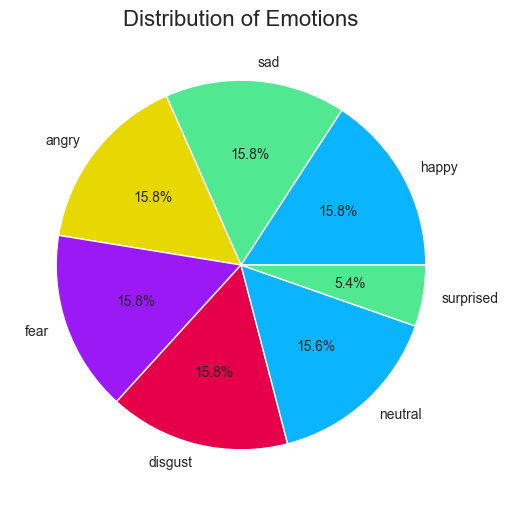

In [8]:
plt.figure(figsize=(10,6))
emotion_percent = merged_df['emotions'].value_counts(normalize=True) * 100

# Set a threshold for small percentage slices
threshold = 5

# Identify emotions below the threshold
small_emotions = emotion_percent[emotion_percent < threshold]

# Create a list of explode values
explode = [0.1 if emotion in small_emotions else 0 for emotion in emotion_percent.index]

# Set the figure size
plt.figure(figsize=(10, 6))

# Define a custom color palette
color_palette = ["#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#e60049"] 

# Create the pie chart with explode values
plt.pie(emotion_percent, labels=emotion_percent.index, autopct='%1.1f%%', colors=color_palette, explode=explode)

# Set the title
plt.title('Distribution of Emotions', size=16)

The pie chart represents the distribution of emotion types in the dataset. <br>
It is evident that apart from the surprised tone with 5.4% , the other types of tones are around 14-16%. <br>
Worth mentioning that the tone 'calm' with its 1.6% distribution in the dataset, was merged with the neutral tone.

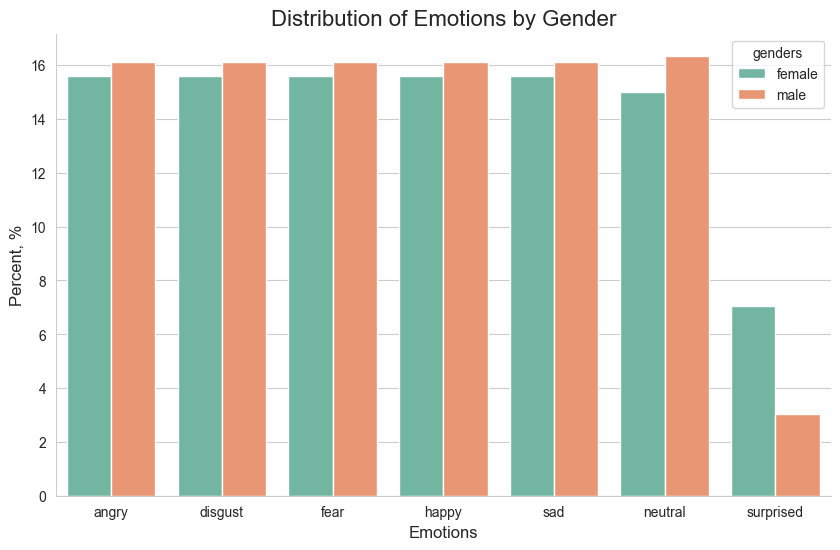

In [9]:
# Calculate the percentage of each emotion by gender
emotions_by_gender = merged_df.groupby('genders')['emotions'].value_counts(normalize=True) * 100

# Reset the index to convert the result into a DataFrame
emotions_by_gender = emotions_by_gender.reset_index(name='percentage')

plt.figure(figsize=(10,6))

sns.barplot(emotions_by_gender, x='emotions', y='percentage', hue='genders', palette='Set2')

plt.title('Distribution of Emotions by Gender', size=16)
plt.xlabel('Emotions', size=12)
plt.ylabel('Percent, %', size=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine() # Remove the top and right spines

The distribution of emotions in the entire dataset by the gender is relatively uniform.

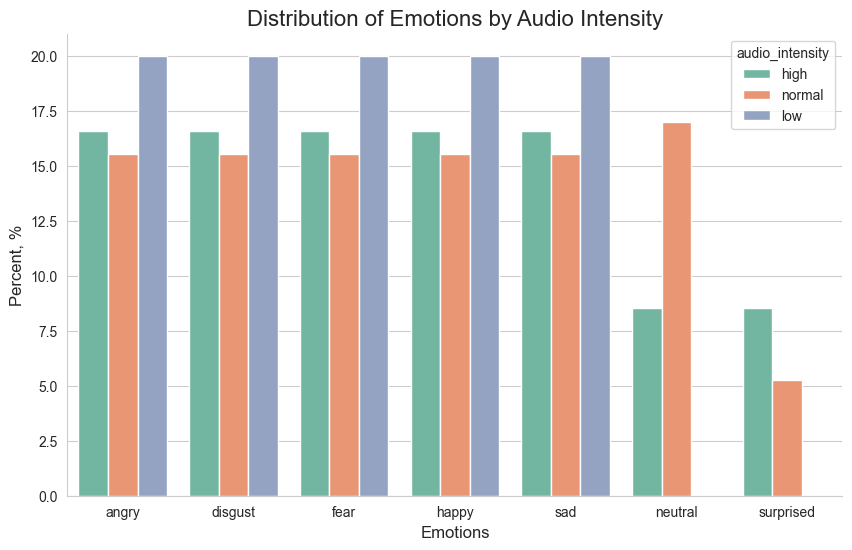

In [10]:
# Calculate the percentage of each emotion by gender
emotions_by_gender = merged_df.groupby('audio_intensity')['emotions'].value_counts(normalize=True) * 100

# Reset the index to convert the result into a DataFrame
emotions_by_gender = emotions_by_gender.reset_index(name='percentage')

plt.figure(figsize=(10,6))

sns.barplot(emotions_by_gender, x='emotions', y='percentage', hue='audio_intensity', hue_order=['high', 'normal', 'low'], palette='Set2')

plt.title('Distribution of Emotions by Audio Intensity', size=16)
plt.xlabel('Emotions', size=12)
plt.ylabel('Percent, %', size=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine() # Remove the top and right spines

The audio intensity distribution is divided by high, normal, and low. Neutral and surprised tones have only two intensities, normal and high. <br>
The total distribution is uniform between all the modes of the tone intensity (15%-20%), where only in neutral tone there is a higher percentage of normal intensity. 

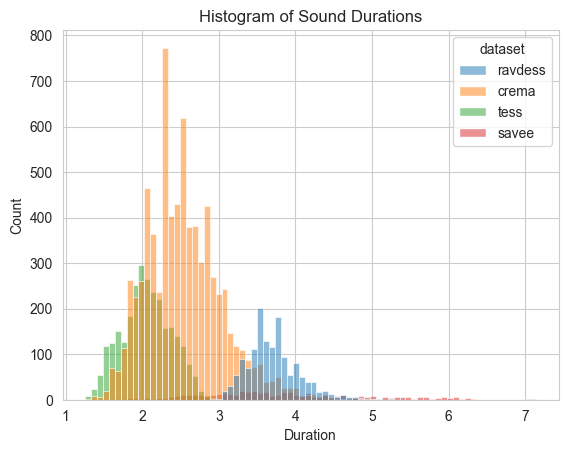

In [11]:
# Create a histogram using seaborn
sns.histplot(data=merged_df, x='duration', hue='dataset')

# Set labels and title
plt.xlabel('Duration')
plt.ylabel('Count')
plt.title('Histogram of Sound Durations')

# Display the histogram
plt.show()

In [12]:
print(f"max input audion duration is {round(merged_df['duration'].max(),2)}")

max input audion duration is 7.14


The audio duration distribution of each dataset is slightly different, with the SAVEE dataset having the biggest spread.
This means that as part of the data preparation for the model, we'll need to pad the audio files with zeroes based on the longest audio files in the dataset.

## 3.2. Demonstration of various audio files

In [13]:
def play_random_audio(dataframe, gender, emotion, intensity, preprocess=False):
    # Filter the DataFrame based on the given criteria
    filtered_df = dataframe[(dataframe['genders'] == gender) & (dataframe['emotions'] == emotion) & (dataframe['audio_intensity'] == intensity)]
    
    # Randomly select an audio file path
    file_path = random.choice(np.array(filtered_df['audio_path']))
    
    # Load the audio file using librosa
    audio, sr = librosa.load(file_path)

    # Applying preprocess
    if preprocess:
        audio = preprocess_audio(audio)
        

    # Display the waveform plot
    plt.figure(figsize=(12, 4))

    # Waveform plot
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(audio, sr=sr)
    plt.title(f'Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Spectrogram plot
    plt.subplot(1, 2, 2)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    img = librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.title('Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Mel frequency')
    plt.colorbar(format='%+2.0f dB')  # A colorbar with dB format

    plt.subplots_adjust(wspace=0.4)  #  Horizontal spacing between subplots
    plt.suptitle(f'Dataset: {dataframe[dataframe["audio_path"]==file_path]["dataset"].values[0]}, Gender: {gender}, Emotion: {emotion}, Intensity: {intensity}', weight='bold', size=16)
    plt.tight_layout()

    # Play the audio
    return ipd.Audio(file_path)

Examples of random audio samples

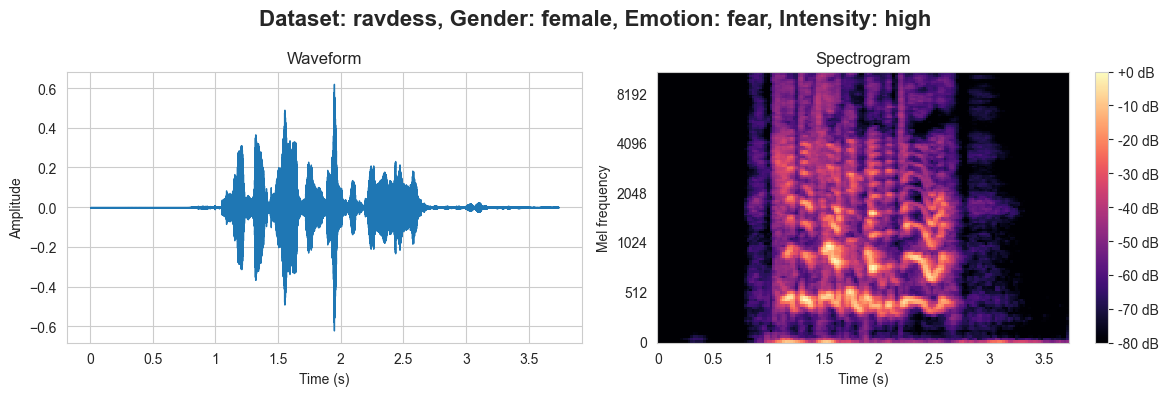

In [14]:
play_random_audio(merged_df, gender="female", emotion="fear", intensity="high")

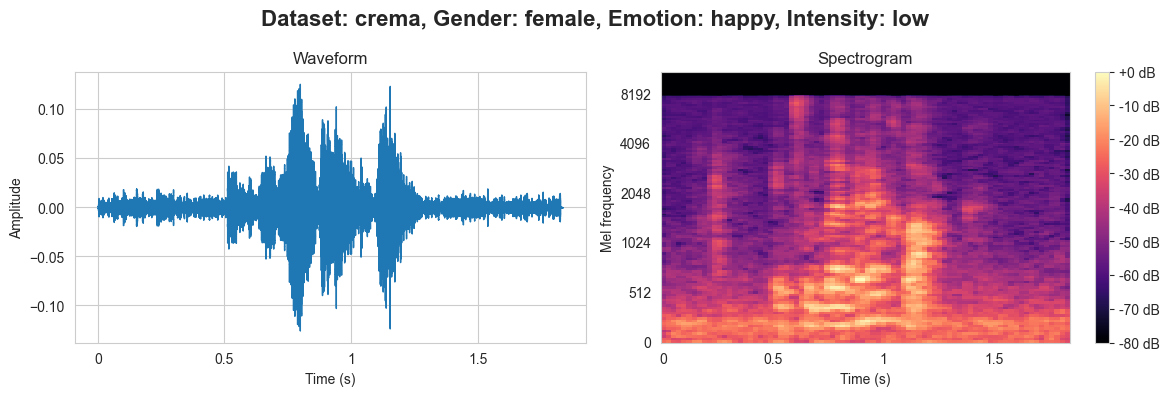

In [15]:
play_random_audio(merged_df, gender="female", emotion="happy", intensity="low")

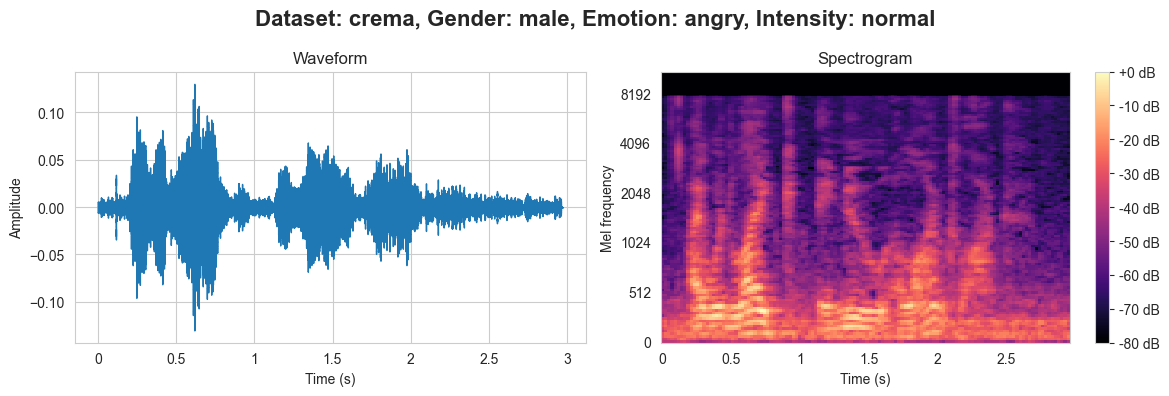

In [16]:
play_random_audio(merged_df, gender="male", emotion="angry", intensity="normal")

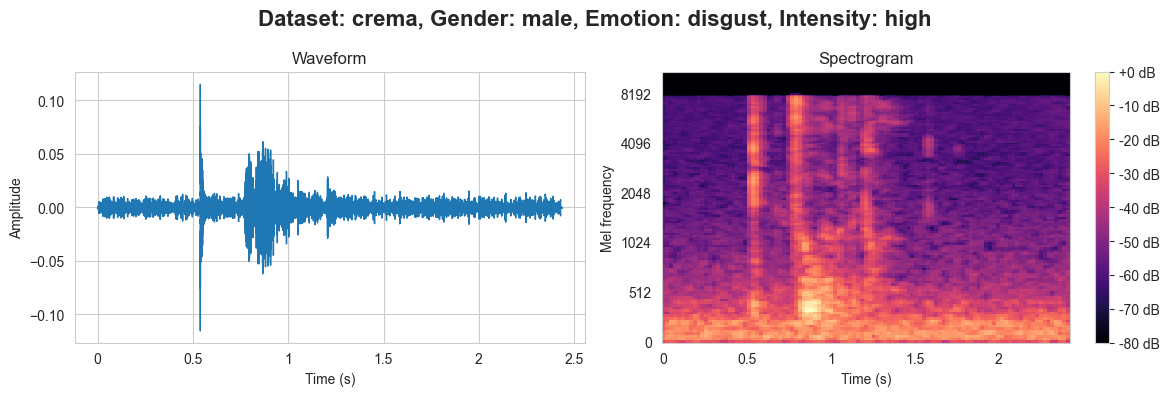

In [17]:
play_random_audio(merged_df, gender="male", emotion="disgust", intensity="high")

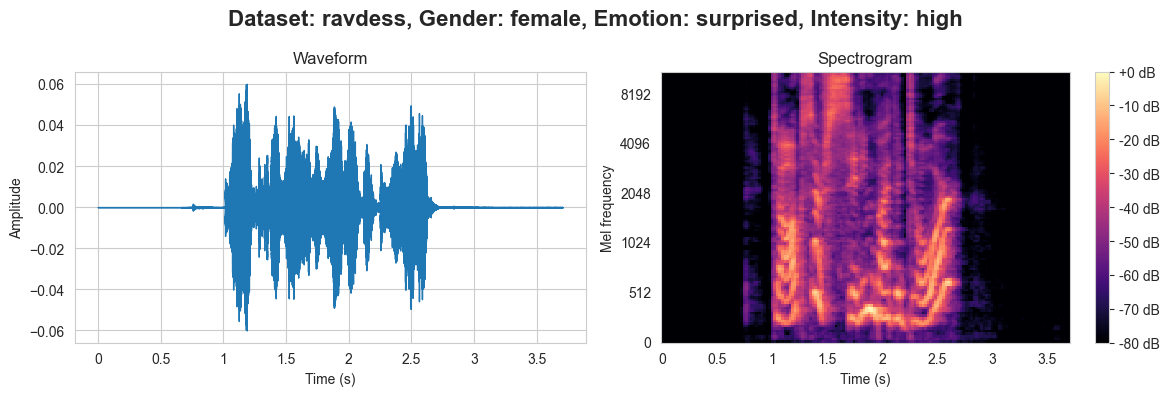

In [18]:
play_random_audio(merged_df, gender="female", emotion="surprised", intensity="high")

Each of the imported datasets originated from a different location, i.e., some with background noise, different sentences, gender of speakers, etc... <br>
This contributes to the quality of the whole data frame and thereafter to the ability of the model to classify an emotion of an unseen dataset. <br>
From the samples above, one can qualitatively distinguish between the various emotions, despite being recorded in different environments (e.g., a studio or with a sort of environmental noise) or if the speaker says a different sentence. <br>

The Mel-frequency spectrogram is designed to better approximate the perception of sound by humans, especially in terms of the frequency resolution. It captures more details in the lower frequencies where human hearing is more sensitive and provides a more perceptually relevant representation compared to the regular spectrogram with a linear frequency scale.








# 4. Feature Extraction & Preprocessing

## 4.1. Data Preprocessing

In [19]:
def preprocess_audio(audio):
    
    # waveform final samples length set to 160000 (~7.2 seconds) for SAVEE dataset compatability
    samples_count = 160000
    
    # maximum decibles considered silence to be removed from start and end of audio
    silence_db = 25
    
    trimmed_audio, _ = librosa.effects.trim(audio, top_db=silence_db)
    padded_trimmed_audio = np.pad(trimmed_audio, (0, samples_count-len(trimmed_audio)), 'constant')
    
    return padded_trimmed_audio

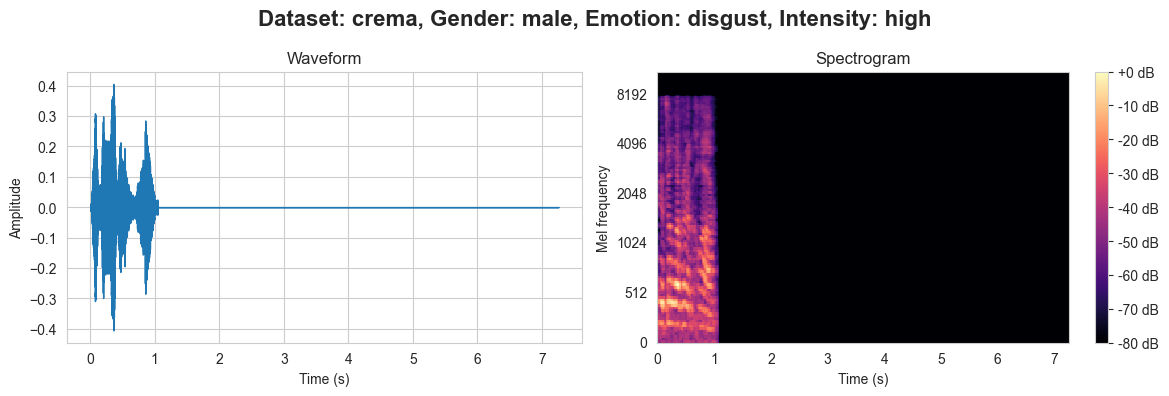

In [20]:
play_random_audio(merged_df, gender="male", emotion="disgust", intensity="high", preprocess=True)

## 4.2. Data Augmentation

In [21]:
class DataAugmentation:
    def __init__(self) -> None:
        pass

    def shift_pitch(self, audio, sr, semitones):
        shifted_audio = librosa.effects.pitch_shift(audio, n_steps=float(semitones), sr=sr)
        return shifted_audio
    
    def time_shift(self, audio, sr, shift_range=5):
        shift_samples = np.random.randint(-shift_range, shift_range)*1000
        shifted_audio = np.roll(audio, shift=shift_samples)
        return shifted_audio
    
    def time_stretch(self, audio, rate):
        stretched_audio = librosa.effects.time_stretch(audio, rate=rate)
        return stretched_audio
    
    def add_noise(self, audio, noise_factor):
        noise = np.random.randn(len(audio))
        noise_factor = noise_factor *np.random.uniform() * np.amax(audio)
        noisy_audio = audio + noise_factor * noise
        return noisy_audio

# Baseline model

## 2D Convolution on Mel-spectrum images

In [38]:
def extract_mfcc(audio_path, num_mfcc=30):
    audio, sr = librosa.load(audio_path)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc)
    return mfcc

In [39]:
def plot_metrics(history, metric):
    train_metric = history.history[metric]
    val_metric = history.history['val_' + metric]
    
    plt.plot(train_metric)
    plt.plot(val_metric)
    plt.title('Model ' + metric)
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [40]:
def create_early_stopping_callback():
    return EarlyStopping(patience=5, monitor="val_loss", mode='min', verbose=1)

def create_model_checkpoint_callback(file_name):
    return ModelCheckpoint(file_name, save_best_only=True, monitor="val_accuracy")

def create_reduce_lr_callback():
    return ReduceLROnPlateau(factor=0.1, patience=3, monitor="val_accuracy", min_lr=0.00001)

In [66]:
num_classes = len(merged_df['emotions'].unique())
class_labels = list(merged_df['emotions'].unique())

In [ ]:
X = []
y = []
max_length = 0

for i, row in merged_df.iterrows():
    audio_path = row['audio_path']
    emotion = row['emotions']
    mfcc = extract_mfcc(audio_path)
    X.append(mfcc)
    y.append(emotion)
    # Update maximum length if needed
    if mfcc.shape[1] > max_length:
        max_length = mfcc.shape[1]

# Apply padding or truncation with the computed maximum length
for i in range(len(X)):
    if X[i].shape[1] < max_length:
        pad_width = max_length - X[i].shape[1]
        X[i] = np.pad(X[i], pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        X[i] = X[i][:, :max_length]

X = np.array(X)
y = np.array(y)

In [ ]:
# Splitting the data into train , val, test datasets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

In [ ]:
print(f'training set shape: {X_train.shape}\nvalidation set shape: {X_val.shape}\ntest set shape: {X_test.shape}')

In [ ]:
# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train_scaled = (X_train - mean)/std
X_val_scaled = (X_val - mean)/std

In [ ]:
# Creating channel dimension for model input
X_train_scaled = X_train_scaled[...,np.newaxis]
X_val_scaled = X_val_scaled[...,np.newaxis]

In [ ]:
X_train_scaled.shape

In [ ]:
# Encode the class labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Convert the class labels to categorical format
y_train_categorical = to_categorical(y_train_encoded, num_classes, dtype='float32')
y_val_categorical = to_categorical(y_val_encoded, num_classes, dtype='float32')

### 3x3 kernel model

In [ ]:
input_shape = X_train_scaled.shape[1:]

# Define the optimizer with an initial learning rate
optimizer = Adam(learning_rate=0.001)

inputs = Input(shape=input_shape)
x = Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

In [ ]:
callbacks = [
    create_early_stopping_callback(),
    create_model_checkpoint_callback("best_model_kernel3by3.h5"),
    create_reduce_lr_callback()
]

history = model.fit(X_train_scaled, 
                    y_train_categorical, 
                    batch_size=32, 
                    epochs=30, 
                    validation_data=(X_val_scaled, y_val_categorical),
                    callbacks=callbacks
                    )

In [ ]:
plot_metrics(history, 'accuracy')
plot_metrics(history, 'loss')

### 4x10 kernel model

Since the MFCC shape is of a wide rectangle, a rectangular kernel might be more fitted for our model Conv2D

In [ ]:
input_shape = X_train_scaled.shape[1:]

# Define the optimizer with an initial learning rate
optimizer = Adam(learning_rate=0.001)

inputs = Input(shape=input_shape)
x = Conv2D(32, kernel_size=(4, 10), activation="relu", padding="same")(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(32, kernel_size=(4, 10), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(64, kernel_size=(4, 10), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(64, kernel_size=(4, 10), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

In [ ]:
callbacks = [
    create_early_stopping_callback(),
    create_model_checkpoint_callback("best_model_kernel4by10.h5"),
    create_reduce_lr_callback()
]

history = model.fit(X_train_scaled, 
                    y_train_categorical, 
                    batch_size=32, 
                    epochs=30, 
                    validation_data=(X_val_scaled, y_val_categorical),
                    callbacks=callbacks
                    )

In [ ]:
plot_metrics(history, 'accuracy')
plot_metrics(history, 'loss')

## Data Augmentation

class DataAugmentation:
    def __init__(self) -> None:
        pass

    def shift_pitch(self, audio, sr, semitones):
        shifted_audio = librosa.effects.pitch_shift(audio, n_steps=float(semitones), sr=sr)
        return shifted_audio
    
    def time_shift(self, audio, sr, shift_range=5):
        shift_samples = np.random.randint(-shift_range, shift_range)*1000
        shifted_audio = np.roll(audio, shift=shift_samples)
        return shifted_audio
    
    def time_stretch(self, audio, rate):
        stretched_audio = librosa.effects.time_stretch(audio, rate=rate)
        return stretched_audio
    
    def add_noise(self, audio, noise_factor):
        noise = np.random.randn(len(audio))
        noise_factor = noise_factor *np.random.uniform() * np.amax(audio)
        noisy_audio = audio + noise_factor * noise
        return noisy_audio

In [22]:
augmentor = DataAugmentation()

In [23]:
merged_df.head()

,emotions,genders,audio_intensity,audio_path,duration,dataset
0,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.303311,ravdess
1,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.336689,ravdess
2,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.269932,ravdess
3,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.169841,ravdess
4,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.536871,ravdess
...,...,...,...,...,...,...
12157,surprised,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,2.014059,savee
12158,surprised,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,3.904263,savee
12159,surprised,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,3.532381,savee
12160,surprised,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,5.267619,savee


In [48]:
# Take a random 75% of the data
random_merged_df = merged_df.sample(frac=0.5, random_state=42)
random_merged_df.reset_index(drop=True, inplace=True)
random_merged_df

,emotions,genders,audio_intensity,audio_path,duration,dataset
0,fear,male,normal,./data/cremad/1087_IOM_FEA_XX.wav,1.868526,crema
1,disgust,male,normal,./data/cremad/1033_DFA_DIS_XX.wav,2.369025,crema
2,angry,female,normal,./data/cremad/1084_TSI_ANG_XX.wav,2.836190,crema
3,angry,female,normal,./data/cremad/1073_ITS_ANG_XX.wav,2.535918,crema
4,sad,female,normal,./data/toronto-emotional-speech-set-tess/OAF_S...,2.726349,tess
...,...,...,...,...,...,...
6076,neutral,female,normal,./data/cremad/1030_DFA_NEU_XX.wav,2.402404,crema
6077,happy,male,normal,./data/cremad/1038_WSI_HAP_XX.wav,2.669342,crema
6078,neutral,male,normal,./data/cremad/1065_TSI_NEU_XX.wav,1.835193,crema
6079,happy,male,normal,./data/cremad/1062_IEO_HAP_MD.wav,2.168844,crema


In [49]:
# Create a new dataframe to store augmented data
augmented_df = pd.DataFrame(columns=random_merged_df.columns)

In [50]:
# Set output folder to save augmented audio files
output_folder = './data/augmented_audio'  


In [51]:
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [52]:
import soundfile as sf

In [53]:
for idx, row in random_merged_df.iterrows():
    audio_path = row['audio_path']
    emotion = row['emotions']
    
    # Load the audio
    audio, sr = librosa.load(audio_path, sr=None)
    
    # Augment the audio using each method in the DataAugmentation class
    shifted_audio = augmentor.shift_pitch(audio, sr, semitones=2)
    time_shifted_audio = augmentor.time_shift(audio, sr, shift_range=5)
    stretched_audio = augmentor.time_stretch(audio, rate=1.2)
    noisy_audio = augmentor.add_noise(audio, noise_factor=0.1)
    
    
    # Save the augmented audio if needed
    output_path = os.path.join(output_folder, f'{emotion}_{idx}.wav')
    sf.write(output_path, shifted_audio, sr)
    
    # Append the augmented data to the augmented_df
    augmented_df = augmented_df.append({
        'emotions': emotion,
        'genders': row['genders'],
        'audio_intensity': row['audio_intensity'],
        'audio_path': output_path,  # Replace with the actual path if not saving
        'duration': row['duration'],
        'dataset': row['dataset']
    }, ignore_index=True)

In [56]:
final_data = pd.concat([merged_df, augmented_df], axis=0)

In [61]:
class MFCCDataCreator:
    def __init__(self, num_mfcc=30):
        self.num_mfcc = num_mfcc
        self.max_length = 0

    def create_data(self, df):
        X = []
        y = []

        for i, row in df.iterrows():
            audio_path = row['audio_path']
            emotion = row['emotions']
            mfcc = self._extract_mfcc(audio_path)
            X.append(mfcc)
            y.append(emotion)
            # Update maximum length if needed
            if mfcc.shape[1] > self.max_length:
                self.max_length = mfcc.shape[1]

        # Apply padding or truncation with the computed maximum length
        for i in range(len(X)):
            if X[i].shape[1] < self.max_length:
                pad_width = self.max_length - X[i].shape[1]
                X[i] = np.pad(X[i], pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                X[i] = X[i][:, :self.max_length]

        X = np.array(X)
        y = np.array(y)

        return X, y
    
    # extract_mfcc function is an internal method
    def _extract_mfcc(self, audio_path):
        audio, sr = librosa.load(audio_path)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=self.num_mfcc)
        return mfcc

In [63]:
data_creator = MFCCDataCreator(num_mfcc=30)


<Axes: xlabel='duration', ylabel='Count'>

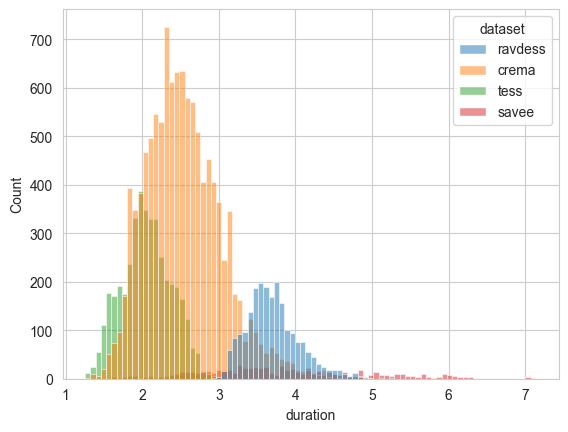

In [76]:
sns.histplot(data=final_data, x='duration', hue='dataset')

In [65]:
X, y = data_creator.create_data(final_data)

In [73]:
max_length

NameError: name 'max_length' is not defined

--------------------

In [ ]:
# Splitting the data into train , val, test datasets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

In [ ]:
# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train_scaled = (X_train - mean)/std
X_val_scaled = (X_val - mean)/std

In [ ]:
# Creating channel dimension for model input
X_train_scaled = X_train_scaled[...,np.newaxis]
X_val_scaled = X_val_scaled[...,np.newaxis]

In [ ]:
# Encode the class labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Convert the class labels to categorical format
y_train_categorical = to_categorical(y_train_encoded, num_classes, dtype='float32')
y_val_categorical = to_categorical(y_val_encoded, num_classes, dtype='float32')

In [ ]:
num_classes = len(merged_df['emotions'].unique())
class_labels = list(merged_df['emotions'].unique())

----------------------------

In [67]:
class DataPreprocessor:
    def __init__(self, X, y, dataframe):
        self.X = X
        self.y = y
        self.dataframe = dataframe
        self.num_classes = len(dataframe['emotions'].unique())
        self.class_labels = list(dataframe['emotions'].unique())
        self.label_encoder = LabelEncoder()
    
    def split_data(self, test_size=0.2, val_size=0.1, random_state=42):
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=val_size, random_state=random_state)
        
        return X_train, X_val, X_test, y_train, y_val, y_test
    
    def normalize_data(self, X_train, X):
        mean = np.mean(X_train, axis=0)
        std = np.std(X_train, axis=0)
        X_scaled = (X - mean) / std
        return X_scaled
    
    def modify_channels(self, X):
        X_modified = X[..., np.newaxis]
        return X_modified
    
    def encode_labels(self, y_train, y_val, y_test):
        y_train_encoded = self.label_encoder.fit_transform(y_train)
        y_val_encoded = self.label_encoder.transform(y_val)
        y_test_encoded = self.label_encoder.transform(y_test)
        return y_train_encoded, y_val_encoded, y_test_encoded
    
    def one_hot_encode_labels(self, y_encoded):
        y_categorical = to_categorical(y_encoded, self.num_classes, dtype='float32')
        return y_categorical
    
    def preprocess_data(self):
        X_train, X_val, X_test, y_train, y_val, y_test = self.split_data()
        X_train_scaled = self.normalize_data(X_train, X_train)
        X_val_scaled = self.normalize_data(X_train, X_val)
        X_test_scaled = self.normalize_data(X_train, X_test)
        X_train_modified = self.modify_channels(X_train_scaled)
        X_val_modified = self.modify_channels(X_val_scaled)
        X_test_modified = self.modify_channels(X_test_scaled)
        y_train_encoded, y_val_encoded, y_test_encoded = self.encode_labels(y_train, y_val, y_test)
        y_train_categorical = self.one_hot_encode_labels(y_train_encoded)
        y_val_categorical = self.one_hot_encode_labels(y_val_encoded)
        y_test_categorical = self.one_hot_encode_labels(y_test_encoded)
        
        return X_train_modified, X_val_modified, X_test_modified, y_train_categorical, y_val_categorical, y_test_categorical


In [68]:
preprocessor = DataPreprocessor(X, y, final_data)
X_train_scaled, X_val_scaled, X_test_scaled, y_train_categorical, y_val_categorical, y_test_categorical = preprocessor.preprocess_data()

In [70]:
X_train_scaled.shape[0:]

(13134, 30, 308, 1)

In [74]:
input_shape = X_train_scaled.shape[1:]

# Define the optimizer with an initial learning rate
optimizer = Adam(learning_rate=0.001)

inputs = Input(shape=input_shape)
x = Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)

x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 308, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 30, 308, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 30, 308, 32)      128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 154, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 154, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 154, 32)       9248  

In [77]:
def create_early_stopping_callback():
    return EarlyStopping(patience=5, monitor="val_loss", mode='min', verbose=1)

def create_model_checkpoint_callback(file_name):
    return ModelCheckpoint(file_name, save_best_only=True, monitor="val_accuracy")

def create_reduce_lr_callback():
    return ReduceLROnPlateau(factor=0.1, patience=3, monitor="val_accuracy", min_lr=0.00001)
callbacks = [
    create_early_stopping_callback(),
    create_model_checkpoint_callback("best_model_kernel3by3.h5"),
    create_reduce_lr_callback()
]

history = model.fit(X_train_scaled, 
                    y_train_categorical, 
                    batch_size=32, 
                    epochs=30, 
                    validation_data=(X_val_scaled, y_val_categorical),
                    callbacks=callbacks
                    )

Epoch 1/30
 51/411 [==>...........................] - ETA: 2:23 - loss: 1.8643 - accuracy: 0.2457

KeyboardInterrupt: 